In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [2]:
datafolder = ''

In [4]:
experiment = 'Eoi400'
model = 'IPSL-CM6A'
folder = datafolder+'Raw_data/'+model+'/'

In [5]:
dsV = xr.open_dataset(folder+experiment+'/vo_100yr.nc')
dsT = xr.open_dataset(folder+experiment+'/thetao_100yr.nc')

if experiment == 'E280':
    dsOHT = xr.open_dataset(folder+experiment+'/hfbasin_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc',decode_times=False)
    dsgyre = xr.open_dataset(folder+experiment+'/htovgyre_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc',decode_times=False)
    dsovrt = xr.open_dataset(folder+experiment+'/htovovrt_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc',decode_times=False)
    dsAMOC = xr.open_dataset(folder+experiment+'/msftyz_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc',decode_times=False)
    dsr = xr.open_dataset(folder+experiment+'/basin_Ofx_IPSL-CM6A-LR_piControl_r1i1p1f1_gn.nc')
    dsice = xr.open_dataset(folder+experiment+'/siconc_SImon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc')
else:
    dsOHT = xr.open_dataset(folder+experiment+'/hfbasin_Omon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc',decode_times=False)
    dsAMOC = xr.open_dataset(folder+experiment+'/msftyz_Omon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc',decode_times=False)
    dsr = xr.open_dataset(folder+experiment+'/basin_Ofx_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn.nc')
    dsice = xr.open_dataset(folder+experiment+'/siconc_SImon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc')

## Separation MOC and gyre OHT component 100-yr average

In [6]:
#Rename to avoid confusion with T and V(U) grid
dsV = dsV.rename({'nav_lon': 'ULONG', 'nav_lat': 'ULAT'})
dsT = dsT.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT'})
dsr = dsr.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT'})

In [7]:
temp = dsT.thetao
region = dsr.basin

#Regrid velocity field to the temperature field, using 0 as a fill value for land to avoid NaN ocean grid cells
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vo.fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*temp/temp #Fills land grid cells with NaN again

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Create DXT grid

In [8]:
dphi = np.zeros([332,362])
lat = dsT.TLAT.values
dphi[:,1:] = lat[:,1:]-lat[:,:-1]
dphi[:,0] = lat[:,0]-lat[:,-1]
dphi = np.radians(dphi)

dtheta = np.zeros([332,362])
lon = dsT.TLONG.values
dtheta[:,1:] = lon[:,1:]-lon[:,:-1]
dtheta[:,0] = lon[:,0]-lon[:,-1]

for j in range(332):
    for i in range(200,300):
        if dtheta[j,i] < -300:
            dtheta[j,i] = dtheta[j,i]+360
dtheta = np.radians(dtheta)

phi1 = np.zeros([332,362])
phi1[:,0] = lat[:,-1]
phi1[:,1:] = lat[:,:-1]
phi1 = np.radians(phi1)

phi2 = np.radians(lat)

r = 6.37122e8 #radius Earth in cm
d = 2*r*np.arcsin(np.sqrt(np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dtheta/2)**2)) #Distance between adjacent cells in i dimension on U grid [cm]
dsT['d'] = xr.DataArray(data=d, dims=("j","i")) 
DXT = np.zeros([332,362])
DXT[:,:-1] = (d[:,1:]+d[:,:-1])/2
DXT[:,-1] = (d[:,0]+d[:,-1])/2

dsT['DXT'] = xr.DataArray(data=DXT, dims=("y","x")) #Grid lengths centered on T-points [cm]

Create DZ array

In [9]:
#1-D array with spacing of depth grid
ds = dsT.copy(deep=True)

dz = np.zeros(len(ds.olevel))
dz[0] = ds.olevel[0].values*2
depth = dz[0]
for i in range(1,len(ds.olevel)):
    dz[i] = (ds.olevel[i]-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
dsV['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
dsT['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
DZ = dsT.DZ

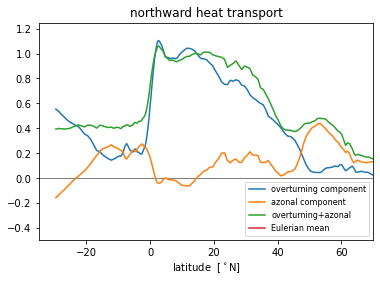

In [10]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

VVEL = vvel.where(region==2) #cm/s
HEAT = (cp_sw*rho_sw*temp).where(region==2)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return xint, zm

#Zonal mean velocity and heat
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsT.DXT.where(VVEL<10000))
HEAT_xint, HEAT_zm = zonal_means(HEAT, dsT.DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])
Haz = (VVEL_prime*HEAT_prime*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

# Auxiliary latitudes for OHT components
lats = dsT.TLAT.where(region==2).mean(dim='x')

plt.figure(figsize=(6,4))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov/1e15, label='overturning component')

plt.plot(lats, Haz/1e15, label='azonal component')
plt.plot(lats, (Hov+Haz)/1e15, label='overturning+azonal')
plt.plot(dsOHT.nav_lat.mean(dim='x'), dsOHT.hfbasin[2400:3600,1,:,0].mean(dim='time')/1e15,label='Eulerian mean')
#plt.plot(dsovrt.nav_lat.mean(dim='x'), dsovrt.htovovrt[2400:3600, 1, :,0].mean(dim='time'), label = 'Model overturning')
#plt.plot(dsgyre.nav_lat.mean(dim='x'), dsgyre.htovgyre[2400:3600, 1, :,0].mean(dim='time'), label = 'Model gyre')
plt.title('northward heat transport')
plt.xlim([-35,70])
plt.ylim([-0.5, 1.25])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [11]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[140:-34]/1e15), OHTaz=(["lat"], Haz[140:-34]/1e15)), coords = dict(lat = lats[140:-34].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC streamfunction

In [12]:
#Select right years/months and replace zeros with NaNs
if experiment == 'Eoi400':
    a = dsAMOC.msftyz[1200:2400,1,:,:,0].mean(dim='time') #streamfunction in kg/s  1.026e-3  # [kg/cm^3]
    b = a/rho_sw/1e12 #kg/s --> cm^3/s --> hm^3/s
    b = b.where(b!=0)
else:
    a = dsAMOC.msftyz[2400:3600,1,:,:,0].mean(dim='time') #streamfunction in kg/s  1.026e-3  # [kg/cm^3]
    b = a/rho_sw/1e12 #kg/s --> cm^3/s --> hm^3/s
    b = b.where(b!=0)

In [13]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), b.values)), coords = dict(z = dsAMOC.olevel.values, lat = dsAMOC.nav_lat[:,0].values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## 100-yr average total Atlantic OHT

In [14]:
if experiment == 'Eoi400':
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.hfbasin[1200:2400,1,:-1,0].mean(dim='time')/1e15).values)), coords = dict(lat = dsOHT.nav_lat[:-1,0].values))
else:
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.hfbasin[2400:3600,1,:-1,0].mean(dim='time')/1e15).values)), coords = dict(lat = dsOHT.nav_lat[:-1,0].values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

##  Annual time series AMOC streamfunction

In [ ]:
if experiment == 'Eoi400':
    a = dsAMOC.msftyz[1200:2400,1,:,:,0] #streamfunction in kg/s  1.026e-3  # [kg/cm^3]
else:
    a = dsAMOC.msftyz[2400:3600,1,:,:,0] #streamfunction in kg/s  1.026e-3  # [kg/cm^3]    
    
amoc = np.zeros([100,75,332])

for i in range(0,100):
    amoc[i] = a[0+i*12:12+i*12].mean(dim='time')

if experiment == 'E280':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(3750, 3850), z = dsAMOC.olevel.values, lat = dsAMOC.nav_lat[:,0].values))
elif experiment == 'Eoi400':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(1950, 2050), z = dsAMOC.olevel.values, lat = dsAMOC.nav_lat[:,0].values))
    
b = dsM2.AMOC/rho_sw/1e12 #kg/s --> cm^3/s --> hm^3/s
b = b.where(b!=0)
dsM2['AMOC'] = b

xr.Dataset.to_netcdf(dsM2, path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## Annual SST timeseries (100 years)

In [15]:
if experiment == 'E280':
    dstos = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/tos_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_355001-384912.nc',decode_times=False)
    dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
    regridder = xe.Regridder(dstos, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
    tos = regridder(dstos.tos[2400:3600])

    tosann = np.zeros([100,180,360])

    for i in range(0,100):
        tosann[i] = tos[0+i*12:12+i*12].mean(dim='time')

    year1 = 3750
    year2 = 3849

elif experiment == 'Eoi400':
    dstos = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/tos_Omon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gn_185001-204912.nc',decode_times=False)
    dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
    regridder = xe.Regridder(dstos, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
    tos = regridder(dstos.tos[1200:3600])
    
    tosann = np.zeros([100,180,360])

    for i in range(0,100):
        tosann[i] = tos[0+i*12:12+i*12].mean(dim='time')

    year1 = 1950
    year2 = 2049
    
dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(year1, year2+1), lat = tos.latitude.values, lon = tos.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr SSS (regridded)

In [16]:
dsS = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/so_100yr.nc')

dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.so[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr sea ice (regridded)

In [17]:
dsi = dsice.drop(['time','type']) #Avoid errors with time when adding months together

sic = dsi.siconc[-1200:] #Select only last 100 years of dataset

djf = (sic[11:1200:12]+sic[0:1200:12]+sic[1:1200:12])/3
djf = djf.mean(dim='time')

mam = (sic[2:1200:12]+sic[3:1200:12]+sic[4:1200:12])/3
mam = mam.mean(dim='time')

jja = (sic[5:1200:12]+sic[6:1200:12]+sic[7:1200:12])/3
jja = jja.mean(dim='time')

son = (sic[8:1200:12]+sic[9:1200:12]+sic[10:1200:12])/3
son = son.mean(dim='time')

dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)
si_mam = regridder(mam)
si_jja = regridder(jja)
si_son = regridder(son)

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr top 100 m salinity

In [18]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("olevel"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.olevel[0:23])

s100m = regridder(dsS.so[0:23].weighted(weights).mean(dim='olevel'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity Atlantic

In [19]:
salt_atl = dsS.so

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.olevel.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature Atlantic

In [20]:
temp_atl = dsT.thetao

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.olevel.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [21]:
if experiment == 'E280':
    dsu = xr.open_dataset(folder+experiment+'/Atm/ua_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_355001-384912.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/va_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_355001-384912.nc')
else:
    dsu = xr.open_dataset(folder+experiment+'/Atm/ua_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc')
    dsv = xr.open_dataset(folder+experiment+'/Atm/va_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc')

In [22]:
ua = dsu.ua[-1200:,0].mean(dim='time')
va = dsv.va[-1200:,0].mean(dim='time')

In [23]:
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
